In [77]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Index
from elasticsearch.helpers import scan

In [78]:
def count_diff_terms(index):
    client = Elasticsearch()
    set_terms = set()
    count_words = 0
    ind = Index(index, using=client)
    if ind.exists():
        sc = scan(client, index=index, doc_type='document', query={"query" : {"match_all": {}}})
        for s in sc:
            tv = client.termvectors(index=index, doc_type='document', id=s['_id'], fields=['text'])
            if 'text' in tv['term_vectors']:
                for t in tv['term_vectors']['text']['terms']:
                    count_words += tv['term_vectors']['text']['terms'][t]['term_freq']
                    set_terms |= {t}
    return count_words, len(set_terms)

def fitting(xdata, ydata, func):
    popt, pcov = curve_fit(
        func, 
        xdata,
        ydata, 
        maxfev=2000
    )
    return popt, pcov

def func_heaps(x, k, b):
    return k*x**b

def fmse(xdata, ydata, popt, func):
    x = np.array(list(map(lambda x: func(x, *popt), xdata)))
    y = np.array(ydata)
    return ((x - y)**2).mean(axis=None)

def plot_data(xdata, ydata, popt_data=None):
    plt.style.use('bmh')
    plt.plot(xdata, ydata, 'ro', label='data')
    plt.xlabel('x')
    plt.ylabel('y', rotation=0)
    if popt_data is not None:
        plt.plot(
            xdata, func_heaps(xdata, *popt_data), 
            'b', 
            label='fit: k=%5.3f, b=%5.3f' % tuple(popt_data)
        )
    plt.legend()
    plt.show()

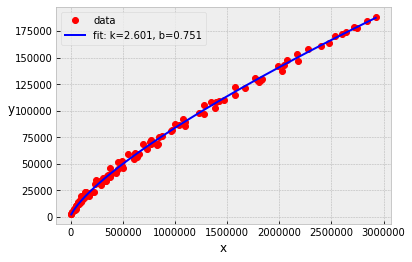

In [79]:
x_data = []
y_data = []
for i in range(0, 120):
    index = 'novels{}'.format(i)
    num_words, num_terms = count_diff_terms(index)
    x_data.append(num_words)
    y_data.append(num_terms)
order = np.argsort(x_data)
x_data = np.array(x_data)[order]
y_data = np.array(y_data)[order]

popt_data, pcov_data = fitting(x_data, y_data, func_heaps)

plot_data(x_data, y_data, popt_data)

In [67]:
fmse(x_data, y_data, popt_data, func_heaps)

6239567.672616124